### Load FreshRetailNet‑50K using Hugging Face

In [1]:
from datasets import load_dataset
import pandas as pd

# Load dataset from Hugging Face
ds = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

# Convert to pandas
train_df = ds['train'].to_pandas()

/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Flatten the hourly arrays

The dataset contains arrays per row (hours_sale, hours_stock_status, etc.). We’ll expand them to one row per hour.

In [2]:
def expand_hourly_rows(row):
    rows = []
    for h in range(24):
        rows.append({
            'city_id': row['city_id'],
            'store_id': row['store_id'],
            'product_id': row['product_id'],
            'date': row['dt'],
            'hour': h,
            'dt_hour': pd.to_datetime(row['dt']) + pd.Timedelta(hours=h),
            'hours_sale': row['hours_sale'][h],
            'hours_stock_status': row['hours_stock_status'][h],
            'discount': row['discount'],
            'holiday_flag': row['holiday_flag'],
            'activity_flag': row['activity_flag'],
            'precpt': row['precpt'],
            'avg_temperature': row['avg_temperature'],
            'avg_humidity': row['avg_humidity'],
            'avg_wind_level': row['avg_wind_level']
        })
    return rows

# Apply to a subset of data for now (e.g., top 10 product-store combos)
subset = train_df[
    (train_df['product_id'] == train_df['product_id'].iloc[0]) &
    (train_df['store_id'] == train_df['store_id'].iloc[0])
]

expanded_rows = []
for _, row in subset.iterrows():
    expanded_rows.extend(expand_hourly_rows(row))

expanded_df = pd.DataFrame(expanded_rows)

### Prepare Data for Latent Demand Modeling

We’ll:
- Select only non-stockout rows to train on real sales.
- Create features for the model (time, weather, promo, etc.)
- Train an XGBoost regressor to predict hours_sale.

NOTE: Everything beyond this is done for a subset of store and products just for initial experimentation.

In [3]:
df_model = expanded_df[expanded_df['hours_stock_status'] == 0].copy()

In [4]:
# Add time-based features
df_model['weekday'] = df_model['dt_hour'].dt.dayofweek  # 0 = Monday

# convert IDs to strings for later encoding
df_model['store_id'] = df_model['store_id'].astype(str)
df_model['product_id'] = df_model['product_id'].astype(str)

# Select modeling features
features = [
    'hour', 'weekday', 'holiday_flag',
    'discount', 'activity_flag',
    'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'
]

X_train = df_model[features]
y_train = df_model['hours_sale']

In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Train-validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_tr, y_tr)

# Evaluate performance
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print("Validation MAE:", round(mae, 4))

Validation MAE: 0.0262


In [8]:
# First, ensure 'imputed_demand' exists in stockout rows
df_stockout = expanded_df[expanded_df['hours_stock_status'] == 1].copy()
df_stockout['weekday'] = df_stockout['dt_hour'].dt.dayofweek
df_stockout['store_id'] = df_stockout['store_id'].astype(str)
df_stockout['product_id'] = df_stockout['product_id'].astype(str)

X_stockout = df_stockout[features]
df_stockout['imputed_demand'] = model.predict(X_stockout)

In [11]:
# Ensure both are string for consistency
df_stockout['store_id'] = df_stockout['store_id'].astype(str)
df_stockout['product_id'] = df_stockout['product_id'].astype(str)

expanded_df['store_id'] = expanded_df['store_id'].astype(str)
expanded_df['product_id'] = expanded_df['product_id'].astype(str)

In [12]:
expanded_df = expanded_df.merge(
    df_stockout[['dt_hour', 'store_id', 'product_id', 'imputed_demand']],
    on=['dt_hour', 'store_id', 'product_id'],
    how='left'
)

In [13]:
expanded_df['final_demand'] = expanded_df['hours_sale']
expanded_df.loc[expanded_df['hours_stock_status'] == 1, 'final_demand'] = expanded_df['imputed_demand']

/var/folders/8r/40hwn8294818myg3mdy2xp0c0000gn/T/ipykernel_89356/3702650203.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


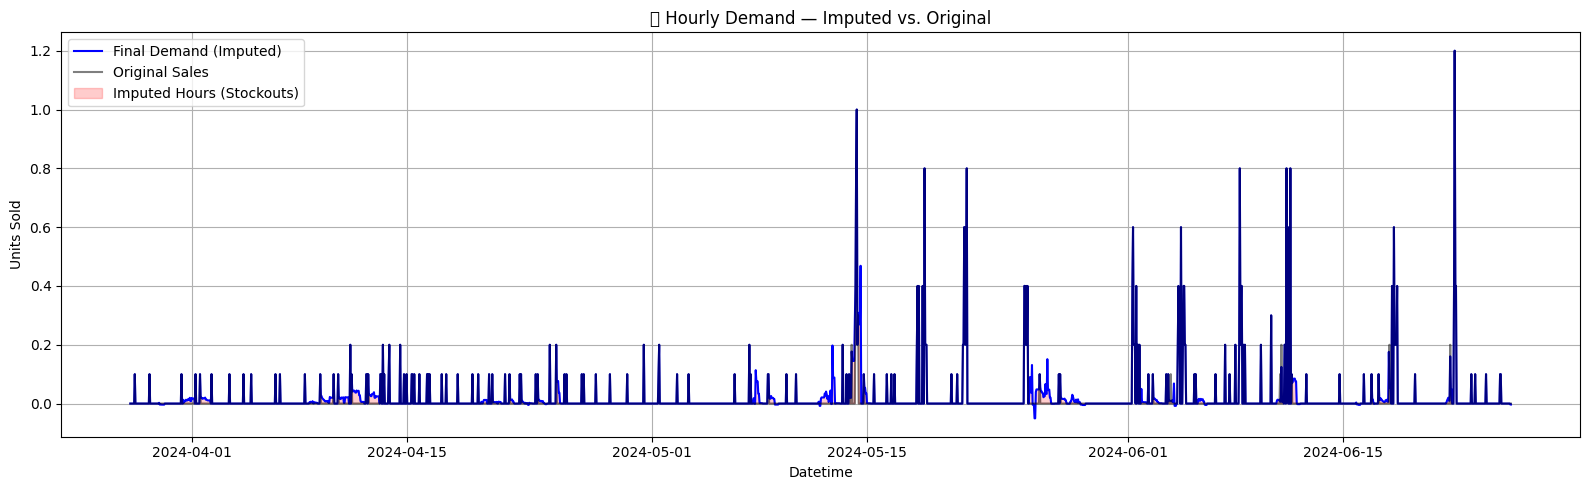

In [14]:
example_combo = expanded_df[
    (expanded_df['product_id'] == expanded_df['product_id'].iloc[0]) &
    (expanded_df['store_id'] == expanded_df['store_id'].iloc[0])
].sort_values('dt_hour')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(example_combo['dt_hour'], example_combo['final_demand'], label='Final Demand (Imputed)', color='blue')
plt.plot(example_combo['dt_hour'], example_combo['hours_sale'], label='Original Sales', color='black', alpha=0.5)

plt.fill_between(
    example_combo['dt_hour'],
    0,
    example_combo['final_demand'],
    where=example_combo['hours_stock_status'] == 1,
    color='red',
    alpha=0.2,
    label='Imputed Hours (Stockouts)'
)

plt.title("📈 Hourly Demand — Imputed vs. Original")
plt.xlabel("Datetime")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Hourly Demand - Imputed vs. Original

- Blue Line → Final Demand (Imputed)
This line shows the demand estimates after filling in stockout periods using a model-based imputation (e.g. XGBoost).
- Grey Line → Original Sales
These are the actual recorded hours_sale values. Noticeable gaps (zeros) likely indicate stockouts.
- Red Shaded Regions → Imputed Hours
These are time periods identified as stockouts, where sales were zero despite expected demand, and thus required imputation.

#### Insights: 
1. Frequent Stockouts:
Red regions occur repeatedly throughout the timeline, especially in the early and mid parts of the series, suggesting that stockouts are common for this product-store combo.
2. Demand Restoration via Imputation:
The imputed demand (blue) smooths out periods where original sales (grey) were missing due to stockouts — helping better reflect true customer demand.
3. Sharp Demand Peaks:
Some sharp spikes are observed in the imputed demand, especially in May and June — these may represent latent demand that was missed due to prolonged stockouts.
4. Low Sales Periods:
Some regions (e.g. early April) show both original and imputed sales near zero — suggesting genuinely low demand rather than stockouts.

#### Conclusion
It visually validates that:
- Stockouts were correctly identified.
- Imputation filled in plausible demand.
- You’ve preserved real zero-demand periods without overestimating.